In [46]:
import numpy as np
import cupy as cp
from scipy.linalg import inv, expm
import networkx as nx
import time
import cupyx.scipy.linalg as cpx_scipy
from cupyx.profiler import benchmark
from matplotlib import pyplot as plt
import os
import 

from qwak_cupy.qwak import QWAK as CQWAK
from qwak.qwak import QWAK as QWAK

# Simple Benchmark

## QWAK

In [57]:
t = 100
n = 500
graph = nx.cycle_graph(n)
initNodes = [n//2]

start_time = time.time()
qw = QWAK(graph)
qw.runWalk(t, initNodes)
end_time = time.time()
qwak_time = end_time - start_time
print(f"QWAK time = {qwak_time}")

QWAK time = 0.4200100898742676


## QWAK CuPy

## 

In [43]:
qw_probVec = qw.getProbVec()
qw_cupy_probVec = qw_cupy.getProbVec()

# Convert the CuPy array to a NumPy array
qw_cupy_probVec_toNp = cp.asnumpy(qw_cupy_probVec)

# Compare the two arrays using np.allclose
are_close = np.allclose(qw_probVec, qw_cupy_probVec_toNp, atol=1e-7)

# Print the result of the comparison
print(f"Are the two arrays approximately equal? {are_close}")
# print(qw_probVec)

Are the two arrays approximately equal? True


## Operator Hamiltonian Equality Test

In [42]:
qw_hamiltonian = qw.getHamiltonian()
qw_cupy_hamiltonian = qw_cupy.getHamiltonian()

# Convert the CuPy array to a NumPy array
qw_cupy_hamiltonian_toNp = cp.asnumpy(qw_cupy_hamiltonian)

# Compare the two arrays using np.allclose
are_close = np.allclose(qw_hamiltonian, qw_cupy_hamiltonian_toNp, atol=1e-7)

# Print the result of the comparison
print(f"Are the two arrays approximately equal? {are_close}")
# print(qw_hamiltonian)
# print()
# print(qw_cupy_hamiltonian)

Are the two arrays approximately equal? True


In [44]:
qw_cupy_probVec_toNp = cp.asnumpy(qw_cupy.getProbVec())

# plt.plot(qw.getProbVec())
# plt.plot(qw_cupy_probVec_toNp,linestyle='dashed')

# Multiple Simple Walks

In [70]:
def runMultipleSimpleQWAK(nList,t):
    qwList = []
    tList = []
    print(f"Running NP QWAK {len(nList)} walks up to n = {nList[-1]}")
    for n in nList:
        print(f"----> Calculating NP QWAK for n = {n}",end='\r')
        start_time = time.time()
        initNodes = [n//2]
        qw = QWAK(nx.cycle_graph(n))
        qw.runWalk(t, initNodes)
        end_time = time.time()
        qwak_time = end_time - start_time
        qwList.append(qw)
        tList.append(qwak_time)
    return tList, qwList

def runMultipleSimpleQWAK_cupy(nList,t):
    qwList = []
    tList = []
    print(f"Running CuPy QWAK {len(nList)} walks up to n = {nList[-1]}")
    for n in nList:
        print(f"----> Calculating CuPy QWAK for n = {n}",end='\r')
        start_time = time.time()
        initNodes = [n//2]
        qw = CQWAK(nx.cycle_graph(n))
        qw.runWalk(t, initNodes)
        end_time = time.time()
        qwak_time = end_time - start_time
        qwList.append(qw)
        tList.append(qwak_time)
    return tList, qwList



t = 50
nMax = 500
nList = list(range(3,nMax,5))
samples = 1

tList, qwList = runMultipleSimpleQWAK(nList,t)
tList_cupy, qwList_cupy = runMultipleSimpleQWAK_cupy(nList,t)

Running NP QWAK 100 walks up to n = 498
Running CuPy QWAK 100 walks up to n = 498


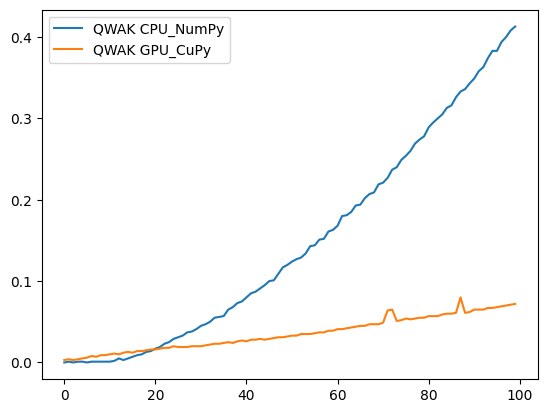

In [63]:
plt.plot(tList,label='QWAK CPU_NumPy')
plt.plot(tList_cupy,label='QWAK GPU_CuPy')
plt.legend()

## Sampling

In [51]:
def runTimedQWAK(n,t):
    start_time = time.time()
    initNodes = [n//2]
    qw = QWAK(nx.cycle_graph(n))
    qw.runWalk(t, initNodes)
    end_time = time.time()
    qwak_time = end_time - start_time
    return qw, qwak_time

def runTimedQWAK_cupy(n,t):
    start_time = time.time()
    initNodes = [n//2]
    qw = CQWAK(nx.cycle_graph(n))
    qw.runWalk(t, initNodes)
    end_time = time.time()
    qwak_time = end_time - start_time
    return qw, qwak_time

def runMultipleSimpleQWAK(nList,t,samples):
    qwList = []
    tList = []
    qwak_time = 0
    qwak_time_average = 0
    print(f"Running NP QWAK {len(nList)} walks up to n = {nList[-1]}")
    for n in nList:
        for sample in range(1,samples+1):
            print(f"----> Calculating NP QWAK for n = {n} \t Sample #{sample}",end='\r')
            qw, qwak_time = runTimedQWAK(n,t)
            qwak_time_average += qwak_time 
        qwak_time_average = qwak_time_average / samples
        qwList.append(qw)
        tList.append(qwak_time_average)
        qwak_time_average = 0
    return tList, qwList

def runMultipleSimpleQWAK_cupy(nList,t,samples):
    qwList = []
    tList = []
    qwak_time = 0
    qwak_time_average = 0
    print(f"Running CuPy QWAK {len(nList)} walks up to n = {nList[-1]}")
    for n in nList:
        # print(f"----> Calculating NP QWAK for n = {n}",end='\r')
        for sample in range(1,samples+1):
            print(f"----> Calculating CuPy QWAK for n = {n} \t Sample #{sample}",end='\r')
            qw, qwak_time = runTimedQWAK_cupy(n,t)
            qwak_time_average += qwak_time 
        qwak_time_average = qwak_time_average / samples
        qwList.append(qw)
        tList.append(qwak_time_average)
        qwak_time_average = 0
    return tList, qwList

In [52]:
# plt.plot(nList,tList,label='QWAK CPU_NumPy')
# plt.plot(nList,tList_cupy,label='QWAK GPU_CuPy')
# plt.legend()

## Writing to file

In [53]:
def load_list_from_file(file_path):
    with open(file_path, 'r') as file:
        data_str = file.read()
    data = [json.loads(line) for line in data_str.splitlines()]
    return data

def write_list_to_file(file_path, data):
    data_str = [str(item) for item in data]  # Convert float values to strings
    with open(file_path, 'w') as file:
        file.write('\n'.join(data_str))
t = 50
nMax = 500
nList = list(range(3,nMax,5))
samples = 1

qwak_times_file = f'Datasets/Benchmark-SimpleQWAK_Cycle/simpleQWAKTime_N{nList[0]}-{nList[-1]}_T{t}_S{samples}.txt'
qwak_times_file_cupy = f'Datasets/Benchmark-SimpleQWAK_Cycle/simpleQWAKTime_CuPy_N{nList[0]}-{nList[-1]}_T{t}_S{samples}.txt'

if os.path.exists(qwak_times_file):
    qwak_times = load_list_from_file(qwak_times_file)
    print('File Exists!')
else:
    qwak_times,qw = runMultipleSimpleQWAK(nList,t,samples)
    write_list_to_file(qwak_times_file,qwak_times)

if os.path.exists(qwak_times_file_cupy):
    qwak_times_cupy = load_list_from_file(qwak_times_file)
    print('File Exists!')
else:
    qwak_times_cupy ,qw = runMultipleSimpleQWAK_cupy(nList,t,samples)
    write_list_to_file(qwak_times_file_cupy,qwak_times)

File Exists!
Running CuPy QWAK 100 walks up to n = 498


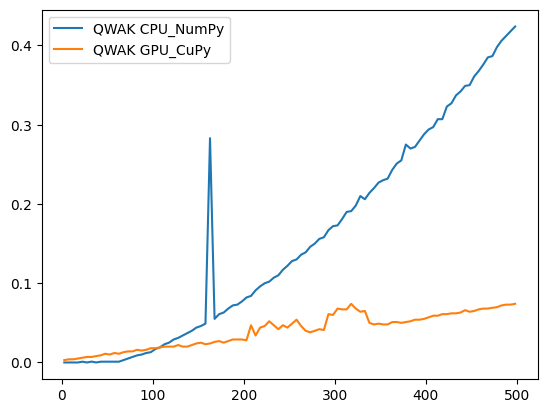

In [54]:
plt.plot(nList,qwak_times,label='QWAK CPU_NumPy')
plt.plot(nList,qwak_times_cupy,label='QWAK GPU_CuPy')
plt.legend()